# Trying to measure the causal impact of mentioning a unusual term on a TV show 

In [35]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
import matplotlib.pyplot as plt

%matplotlib inline

# Time series

In [36]:
os.listdir("data")

['temperatura.csv',
 'carro.csv',
 'restaurante.csv',
 'sororidade.csv',
 'futebol.csv',
 'bbb.csv',
 'globo.csv']

In [39]:
df = (pd.read_csv("data/sororidade.csv", skiprows=1)
      .merge(pd.read_csv("data/temperatura.csv", skiprows=1), on="Tempo")
      .merge(pd.read_csv("data/carro.csv", skiprows=1), on="Tempo")
      .merge(pd.read_csv("data/restaurante.csv", skiprows=1), on="Tempo")
      .merge(pd.read_csv("data/futebol.csv", skiprows=1), on="Tempo")
      .merge(pd.read_csv("data/bbb.csv", skiprows=1), on="Tempo")
      .merge(pd.read_csv("data/globo.csv", skiprows=1), on="Tempo"))

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 167
Data columns (total 8 columns):
Tempo                    168 non-null object
sororidade: (Brasil)     168 non-null object
temperatura: (Brasil)    168 non-null int64
carro: (Brasil)          168 non-null int64
restaurante: (Brasil)    168 non-null int64
futebol: (Brasil)        168 non-null int64
bbb: (Brasil)            168 non-null int64
globo: (Brasil)          168 non-null int64
dtypes: int64(6), object(2)
memory usage: 11.8+ KB


In [41]:
df["sororidade: (Brasil)"] = df["sororidade: (Brasil)"].astype(str).str.replace("<", "", regex=False).astype(int)

In [42]:
df.shape

(168, 8)

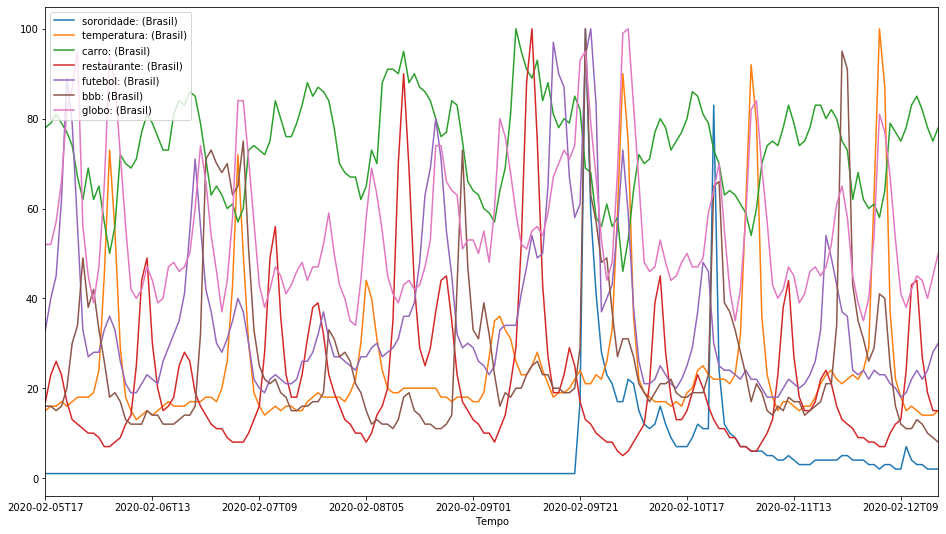

In [43]:
df.set_index("Tempo").plot(figsize=[16,9])

In [44]:
df = df.set_index("Tempo")

In [45]:
y = df["sororidade: (Brasil)"]

In [46]:
df.columns

Index(['sororidade: (Brasil)', 'temperatura: (Brasil)', 'carro: (Brasil)',
       'restaurante: (Brasil)', 'futebol: (Brasil)', 'bbb: (Brasil)',
       'globo: (Brasil)'],
      dtype='object')

In [47]:
X = df[['temperatura: (Brasil)', 'carro: (Brasil)',
       'restaurante: (Brasil)', 'futebol: (Brasil)',
       'bbb: (Brasil)', 'globo: (Brasil)']]

In [48]:
df.index.values

array(['2020-02-05T17', '2020-02-05T18', '2020-02-05T19', '2020-02-05T20',
       '2020-02-05T21', '2020-02-05T22', '2020-02-05T23', '2020-02-06T00',
       '2020-02-06T01', '2020-02-06T02', '2020-02-06T03', '2020-02-06T04',
       '2020-02-06T05', '2020-02-06T06', '2020-02-06T07', '2020-02-06T08',
       '2020-02-06T09', '2020-02-06T10', '2020-02-06T11', '2020-02-06T12',
       '2020-02-06T13', '2020-02-06T14', '2020-02-06T15', '2020-02-06T16',
       '2020-02-06T17', '2020-02-06T18', '2020-02-06T19', '2020-02-06T20',
       '2020-02-06T21', '2020-02-06T22', '2020-02-06T23', '2020-02-07T00',
       '2020-02-07T01', '2020-02-07T02', '2020-02-07T03', '2020-02-07T04',
       '2020-02-07T05', '2020-02-07T06', '2020-02-07T07', '2020-02-07T08',
       '2020-02-07T09', '2020-02-07T10', '2020-02-07T11', '2020-02-07T12',
       '2020-02-07T13', '2020-02-07T14', '2020-02-07T15', '2020-02-07T16',
       '2020-02-07T17', '2020-02-07T18', '2020-02-07T19', '2020-02-07T20',
       '2020-02-07T21', '

In [52]:
df

,sororidade: (Brasil),temperatura: (Brasil),carro: (Brasil),restaurante: (Brasil),futebol: (Brasil),bbb: (Brasil),globo: (Brasil)
Tempo,,,,,,,
2020-02-05 17:00:00,1,15,78,17,33,16,52
2020-02-05 18:00:00,1,16,79,23,40,16,52
2020-02-05 19:00:00,1,16,81,26,45,15,57
2020-02-05 20:00:00,1,17,79,23,62,16,66
2020-02-05 21:00:00,1,16,77,17,89,20,82
2020-02-05 22:00:00,1,17,74,13,79,30,87
2020-02-05 23:00:00,1,18,67,12,56,34,95
2020-02-06 00:00:00,1,18,62,11,33,49,56
2020-02-06 01:00:00,1,18,69,10,27,38,45


In [61]:
np.min(df.index.values)

numpy.datetime64('2020-02-05T17:00:00.000000000')

In [64]:
pd.to_datetime(np.datetime64('2020-02-05T17:00:00.000000000'))

Timestamp('2020-02-05 17:00:00')

In [71]:
df.iloc[:, 0]

Tempo
2020-02-05 17:00:00    1
2020-02-05 18:00:00    1
2020-02-05 19:00:00    1
2020-02-05 20:00:00    1
2020-02-05 21:00:00    1
                      ..
2020-02-12 12:00:00    3
2020-02-12 13:00:00    3
2020-02-12 14:00:00    2
2020-02-12 15:00:00    2
2020-02-12 16:00:00    2
Name: sororidade: (Brasil), Length: 168, dtype: int64

/home/funcional/anaconda3/envs/data_science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    11.78              789.0
Prediction (s.d.)         1.23 (0.28)        82.27 (18.63)
95% CI                    [0.67, 1.76]       [44.81, 117.86]

Absolute effect (s.d.)    10.55 (0.28)       706.73 (18.63)
95% CI                    [10.02, 11.11]     [671.14, 744.19]

Relative effect (s.d.)    859.02% (22.65%)   859.02% (22.65%)
95% CI                    [815.77%, 904.55%] [815.77%, 904.55%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 11.78. By contrast, in the absence of an
intervention, we would have expected an average response of 1.23.
The 95% interval of this counterfactual prediction is [0.67, 1.76].
Subtracting this prediction from the o

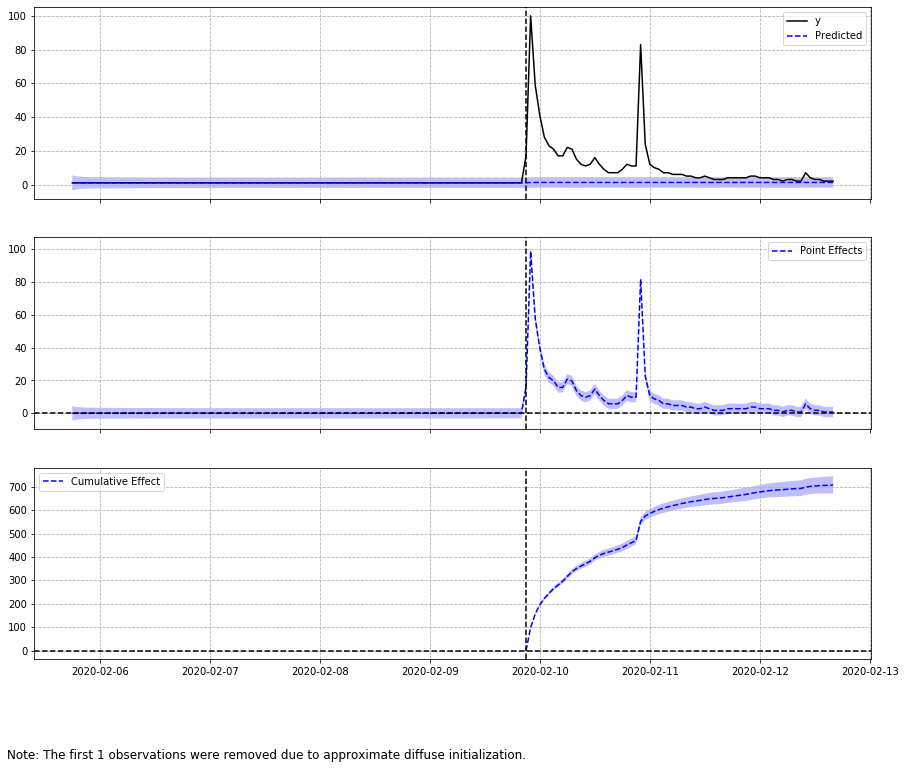

In [96]:
pre_period = [pd.to_datetime(np.min(df.index.values)), pd.to_datetime(np.datetime64('2020-02-09T21:00:00.000000000'))]
post_period = [pd.to_datetime(np.datetime64('2020-02-09T22:00:00.000000000')), pd.to_datetime(np.max(df.index.values))]

ci = CausalImpact(df.iloc[:, 0], pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

In [76]:
y

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,  17, 100,  59,  41,
        28,  23,  21,  17,  17,  22,  21,  15,  12,  11,  12,  16,  12,
         9,   7,   7,   7,   9,  12,  11,  11,  83,  24,  12,  10,   9,
         7,   7,   6,   6,   6,   5,   5,   4,   4,   5,   4,   3,   3,
         3,   4,   4,   4,   4,   4,   5,   5,   4,   4,   4,   3,   3,
         2,   3,   3,   2,   2,   7,   4,   3,   3,   2,   2,   2])

In [77]:
X = df.iloc[:, 1].values
X

array([ 15,  16,  16,  17,  16,  17,  18,  18,  18,  19,  24,  45,  73,
        55,  29,  18,  15,  13,  14,  15,  14,  15,  16,  17,  16,  16,
        16,  17,  17,  17,  18,  18,  17,  20,  26,  43,  72,  50,  30,
        19,  16,  14,  15,  16,  15,  16,  16,  15,  15,  17,  18,  19,
        18,  18,  18,  18,  17,  19,  22,  30,  44,  40,  31,  24,  20,
        19,  19,  20,  20,  20,  20,  20,  20,  20,  18,  18,  17,  18,
        18,  18,  17,  17,  19,  27,  35,  36,  33,  31,  26,  23,  23,
        25,  28,  24,  21,  18,  19,  19,  20,  22,  24,  21,  21,  23,
        22,  26,  33,  59,  90,  75,  36,  22,  19,  18,  17,  17,  17,
        16,  17,  16,  19,  20,  24,  25,  23,  22,  22,  22,  21,  23,
        32,  61,  92,  79,  36,  23,  18,  15,  17,  17,  16,  15,  16,
        16,  18,  21,  23,  24,  22,  21,  22,  23,  22,  24,  29,  63,
       100,  87,  37,  22,  18,  15,  16,  15,  14,  14,  14,  15])

In [78]:
len(X)

168

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    11.78              789.0
Prediction (s.d.)         1.24 (0.27)        83.27 (18.07)
95% CI                    [0.72, 1.77]       [48.04, 118.87]

Absolute effect (s.d.)    10.53 (0.27)       705.73 (18.07)
95% CI                    [10.0, 11.06]      [670.13, 740.96]

Relative effect (s.d.)    847.54% (21.7%)    847.54% (21.7%)
95% CI                    [804.79%, 889.85%] [804.79%, 889.85%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 11.78. By contrast, in the absence of an
intervention, we would have expected an average response of 1.24.
The 95% interval of this counterfactual prediction is [0.72, 1.77].
Subtracting this prediction from the ob

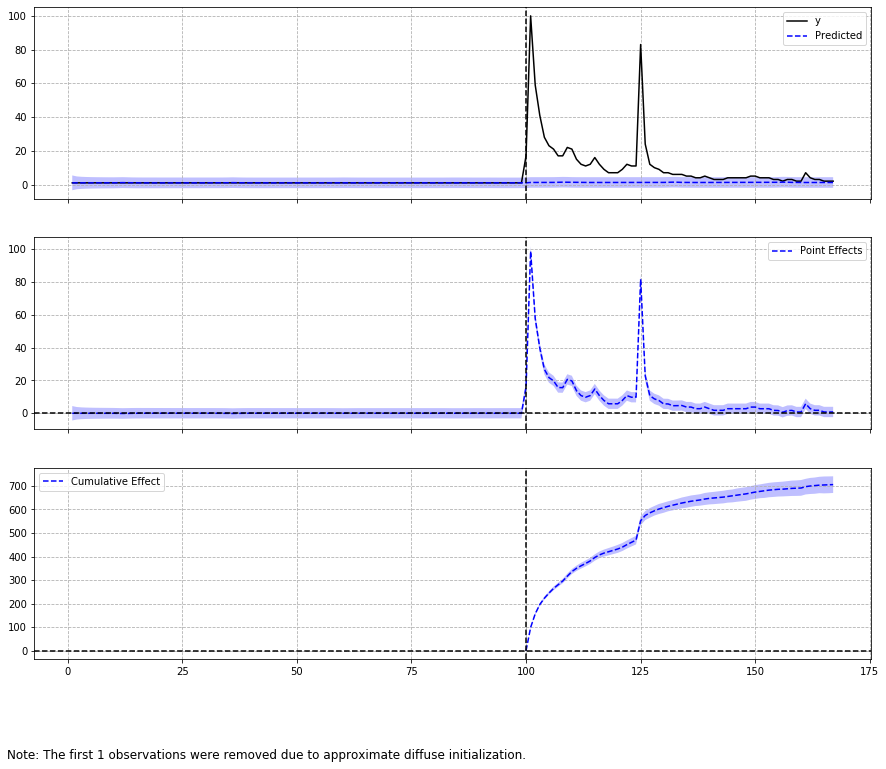

In [95]:
data = pd.DataFrame({'y': y, 'X': X}, columns=['y', 'X'])
pre_period = [0, 100]
post_period = [101, 167]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()